<a href="https://colab.research.google.com/github/pea-sys/Til/blob/master/3_3_%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%82%92%E5%88%A9%E7%94%A8%E3%81%97%E3%81%9F%E3%83%A1%E3%83%BC%E3%83%AB%E3%83%9E%E3%83%BC%E3%82%B1%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%E6%96%BD%E7%AD%96%E3%81%AE%E5%8A%B9%E6%9E%9C%E6%8E%A8%E5%AE%9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

書籍「効果検証入門」の写経です。  
環境：GoogleColab  
言語：R  

In [1]:
# (1) ライブラリのインストール（初回のみ）
install.packages("cobalt")
install.packages("WeightIt")
install.packages("MatchIt")
install.packages("Matching")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gridExtra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Matching’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# (2) tidyverseの読み出し
library("tidyverse")
library("broom")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
# (3) データの読み込み
email_data <- read_csv("http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
sample_n(email_data,5)

Parsed with column specification:
cols(
  recency = col_double(),
  history_segment = col_character(),
  history = col_double(),
  mens = col_double(),
  womens = col_double(),
  zip_code = col_character(),
  newbie = col_double(),
  channel = col_character(),
  segment = col_character(),
  visit = col_double(),
  conversion = col_double(),
  spend = col_double()
)



recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
3,2) $100 - $200,198.36,1,0,Urban,1,Phone,No E-Mail,0,0,0
4,1) $0 - $100,55.04,1,0,Surburban,1,Web,Mens E-Mail,0,0,0
1,5) $500 - $750,641.13,0,1,Surburban,1,Web,Womens E-Mail,0,0,0
9,1) $0 - $100,29.99,0,1,Surburban,1,Web,No E-Mail,0,0,0
12,1) $0 - $100,35.58,1,0,Urban,0,Phone,No E-Mail,0,0,0


In [4]:
# (4) 女性向けメールが配信されたデータを削除したデータを作成
male_df <- email_data %>%
  filter(segment != "Womens E-Mail") %>% # 女性向けメールが配信されたデータを削除
  mutate(treatment = ifelse(segment == "Mens E-Mail", 1, 0)) # 介入を表すtreatment変数を追加

sample_n(male_df,5)

recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
7,3) $200 - $350,312.77,1,0,Urban,0,Multichannel,No E-Mail,1,0,0,0
11,4) $350 - $500,437.43,0,1,Rural,1,Multichannel,No E-Mail,0,0,0,0
2,3) $200 - $350,264.19,1,0,Urban,1,Web,No E-Mail,0,0,0,0
9,1) $0 - $100,54.99,0,1,Surburban,1,Web,Mens E-Mail,0,0,0,1
6,3) $200 - $350,329.21,1,0,Urban,1,Multichannel,Mens E-Mail,0,0,0,1


In [5]:
# (5) セレクションバイアスのあるデータを作成
## seedを固定する
set.seed(1)
## 条件に反応するサンプルの量を半分にする
obs_rate_c <- 0.5
obs_rate_t <- 0.5

In [6]:
## バイアスのあるデータを作成
biased_data <- male_df %>%
  mutate(obs_rate_c = ifelse( (history > 300) | (recency < 6) | (channel == "Multichannel"), obs_rate_c, 1),
         obs_rate_t = ifelse( (history > 300) | (recency < 6) | (channel == "Multichannel"), 1, obs_rate_t),
         random_number = runif(n = NROW(male_df))) %>%
  filter( (treatment == 0 & random_number < obs_rate_c ) |
            (treatment == 1 & random_number < obs_rate_t) )

# (6) 傾向スコアの推定
ps_model <- glm(data = biased_data,
                formula = treatment ~ recency + history + channel,
                family = binomial)

In [7]:
# (7) 傾向スコアマッチング
## ライブラリの読み込み
library("MatchIt")

## 傾向スコアを利用したマッチング
m_near <- matchit(formula = treatment ~ recency + history + channel,
                  data = biased_data,
                  method = "nearest",
                  replace = TRUE)


## マッチング後のデータを作成
matched_data <- match.data(m_near)

## マッチング後のデータで効果の推定
PSM_result <- lm(data = matched_data,
                 formula = spend ~ treatment) %>%
  tidy()

 cobalt (Version 4.2.2, Build Date: 2020-06-26 15:50:03 UTC)


Attaching package: ‘cobalt’


The following object is masked from ‘package:MatchIt’:

    lalonde


Warning message:
“Standardized mean differences and raw mean differences are present in the same plot. 
Use the 'stars' argument to distinguish between them and appropriately label the x-axis.”
Warning message:
“Standardized mean differences and raw mean differences are present in the same plot. 
Use the 'stars' argument to distinguish between them and appropriately label the x-axis.”


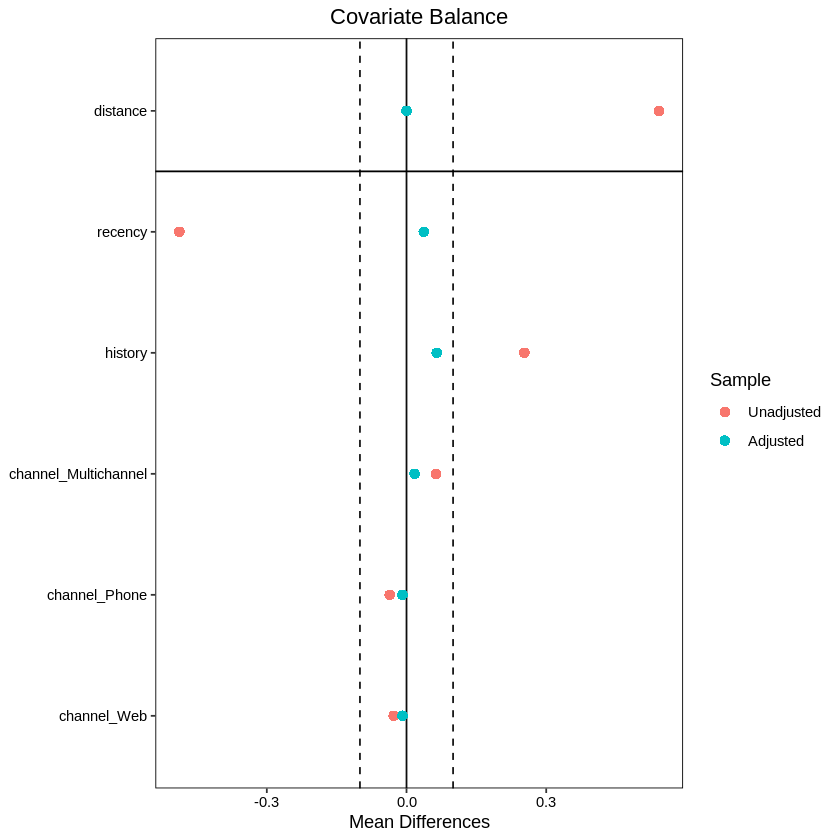

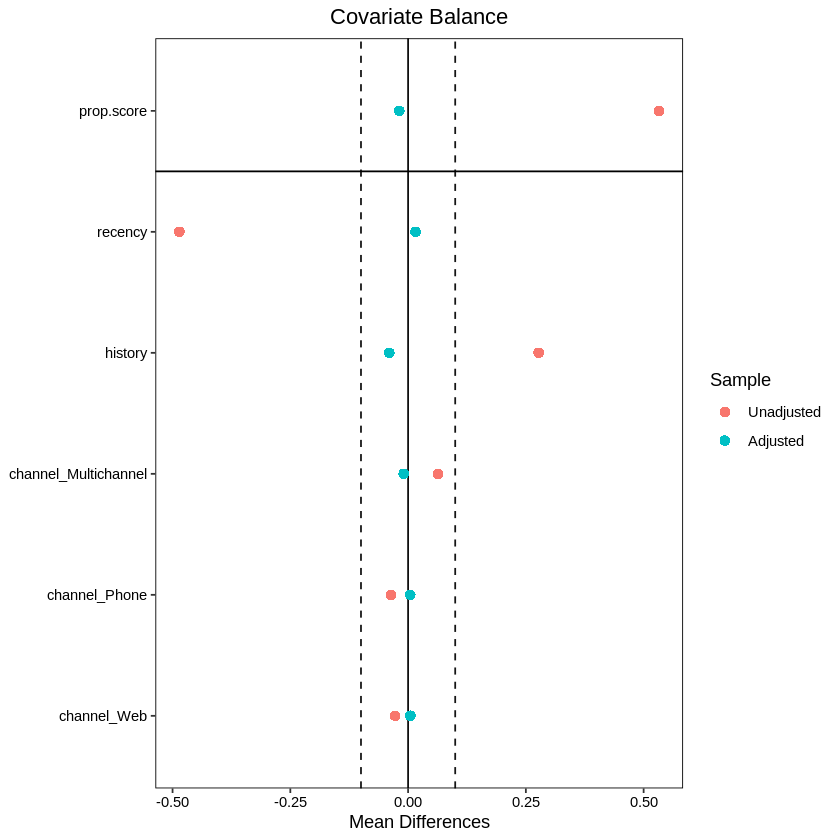

In [8]:
# (8) 逆確率重み付き推定（IPW）
## ライブラリの読み込み
library("WeightIt")

## 重みの推定
weighting <- weightit(treatment ~ recency + history + channel,
              data = biased_data,
              method = "ps",
              estimand = "ATE")

## 重み付きデータでの効果の推定
IPW_result <- lm(data = biased_data,
                 formula = spend ~ treatment,
                 weights = weighting$weights) %>%
  tidy()

# (9) 共変量のバランスを確認
##ライブラリの読み込み
library("cobalt")

## マッチングしたデータでの共変量のバランス
love.plot(m_near,
          threshold = .1)

## 重み付きデータでの共変量のバランス
love.plot(weighting,
          threshold = .1)

In [10]:
# (10) 統計モデルを用いたメールの配信のログを分析
## 学習データと配信ログを作るデータに分割
set.seed(1)

train_flag <- sample(NROW(male_df), NROW(male_df)/2, replace = FALSE)

male_df_train <- male_df[train_flag,] %>%
  filter(treatment == 0)

male_df_test <- male_df[-train_flag,]

## 売上が発生する確率を予測するモデルを作成
predict_model <- glm(data = male_df_train,
                     formula = conversion ~ recency + history_segment +
                       channel + zip_code,
                     family = binomial)

In [11]:
## 売上の発生確率からメールの配信確率を決める
pred_cv <- predict(predict_model,
                   newdata = male_df_test,
                   type = "response")
pred_cv_rank <- percent_rank(pred_cv)

## 配信確率を元にメールの配信を決める
mail_assign <- sapply(pred_cv_rank, rbinom, n = 1, size = 1)

## 配信ログを作成
ml_male_df <- male_df_test %>%
  mutate(mail_assign = mail_assign,
         ps = pred_cv_rank) %>%
  filter( (treatment == 1 & mail_assign == 1) |
            (treatment == 0 & mail_assign == 0) )

In [12]:
## 実験をしていた場合の平均の差を確認
rct_male_lm <- lm(data = male_df_test, formula = spend ~ treatment) %>%
  tidy()
rct_male_lm

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.6417370,0.1465706,4.378347,1.201525e-05
treatment,0.7636348,0.2074234,3.681527,2.324132e-04


In [13]:
## 平均の比較
ml_male_lm <- lm(data = ml_male_df, formula = spend ~ treatment) %>%
  tidy()
ml_male_lm

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.5109855,0.2118040,2.412539,0.0158588178
treatment,1.0800365,0.2992805,3.608777,0.0003090708


In [15]:
## 傾向スコアマッチングの推定(TPS)
library(Matching)
PSM_result <- Match(Y = ml_male_df$spend,
                    Tr = ml_male_df$treatment,
                    X = ml_male_df$ps,
                    estimand = "ATT")
## 推定結果の表示
summary(PSM_result)


Estimate...  1.279 
AI SE......  0.71604 
T-stat.....  1.7862 
p.val......  0.074063 

Original number of observations..............  10530 
Original number of treated obs...............  5274 
Matched number of observations...............  5274 
Matched number of observations  (unweighted).  81531 



Warning message:
“Standardized mean differences and raw mean differences are present in the same plot. 
Use the 'stars' argument to distinguish between them and appropriately label the x-axis.”


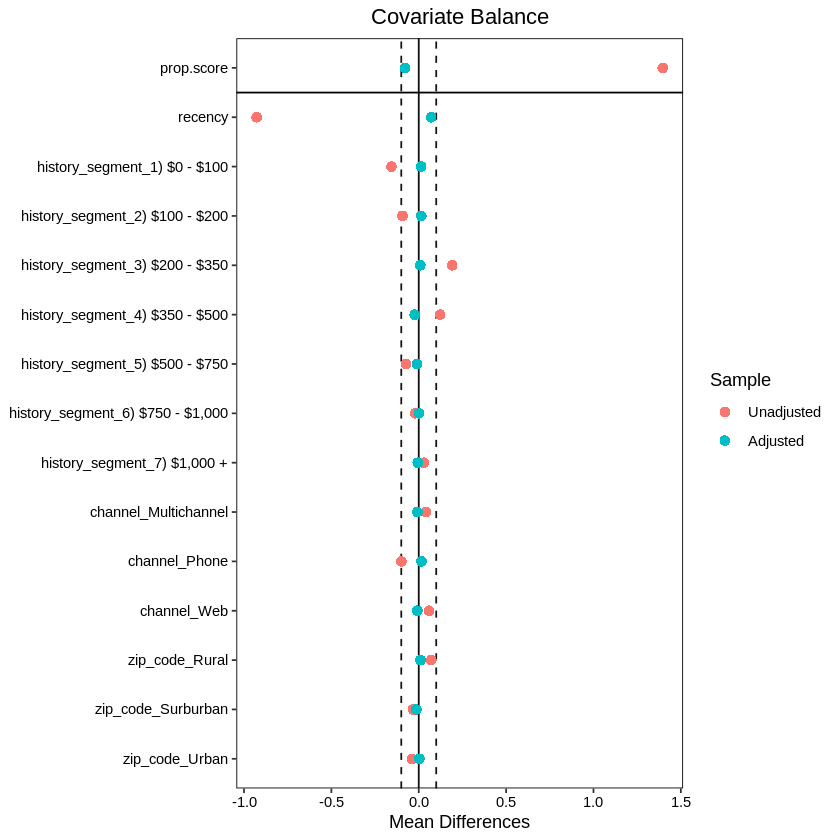

In [16]:
## IPWの推定
W.out <- weightit(treatment ~ recency + history_segment +
                    channel + zip_code,
                  data = ml_male_df,
                  ps = ml_male_df$ps,
                  method = "ps",
                  estimand = "ATE")

## 重み付けしたデータでの共変量のバランスを確認
love.plot(W.out,
          threshold = .1)

## 重みづけしたデータでの効果の分析
IPW_result <- ml_male_df %>%
  lm(data = .,
     spend ~ treatment,
     weights = W.out$weights) %>%
  tidy()

In [17]:
IPW_result 

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.3916202,0.2320099,1.687946,9.145118e-02
treatment,1.3467662,0.3271397,4.116792,3.871138e-05
